In [1]:
#!pip install "../input/mtcnndetect/mtcnn-0.1.0-py3-none-any.whl"

In [2]:
import tensorflow.compat.v1 as tf
import os
import tensorflow.keras.backend as k
from tensorflow.keras.models import Sequential,load_model,Model
from tensorflow.keras.layers import  Conv2D , MaxPooling2D , Activation,UpSampling2D,Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import cv2
import numpy as np
import pandas as pd
from PIL import Image
#from mtcnn import MTCNN
import random
#BATCH_SIZE = 64
IMG_WIDTH = 150
IMG_HEIGHT = 150

In [3]:
from tensorflow.keras.layers import Input, ZeroPadding2D,Lambda
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
tf.disable_eager_execution()
import math
import cv2

In [4]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.compat.v1.GraphDef()
    with tf.io.gfile.GFile('../input/mobilenetface/frozen_inference_graph_face.pb', 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
        config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess=tf.compat.v1.Session(graph=detection_graph, config=config)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    boxes_tensor = detection_graph.get_tensor_by_name('detection_boxes:0')    
    scores_tensor = detection_graph.get_tensor_by_name('detection_scores:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

In [5]:
def get_mobilenet_face(image):
    global boxes,scores,num_detections
    (im_height,im_width)=image.shape[:-1]
    imgs=np.array([image])
    (boxes, scores) = sess.run(
        [boxes_tensor, scores_tensor],
        feed_dict={image_tensor: imgs})
    max_=np.where(scores==scores.max())[0][0]
    box=boxes[0][max_]
    ymin, xmin, ymax, xmax = box
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    left, right, top, bottom = int(left), int(right), int(top), int(bottom)
    return (left, right, top, bottom)
def crop_image(frame,bbox):
    left, right, top, bottom=bbox
    return frame[top:bottom,left:right]
def get_img(frame):
    return cv2.resize(crop_image(frame,get_mobilenet_face(frame)),(IMG_WIDTH,IMG_HEIGHT))

In [6]:
#yolo_model = FaceDetector()
#detector = MTCNN()

In [7]:
def get_preds_(filename,model,interval=4):
    preds = []
    cap = cv2.VideoCapture(filename)
    v_len = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_n = 0
    m = -3
    #lists = [0, 1, 2, 3, 7, 19, 31, 43, 59, 73, 97, 109, 127, 139, 157, 167, 181, 211, 223]
    lists = np.linspace(0,v_len,interval, endpoint=False, dtype=np.int)
    #lists = random.sample(range(5,35),k=1)
    while(cap.isOpened()):
        ret,frame = cap.read() #ret is a boolean variable that returns true if the frame is available
        
        if (frame_n in lists)  :
            if not ret:
                break
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            try:
                newm = get_img(image)
                pred0 = np.float16(model.predict([[newm/127.5 -1]]).clip(0.05,0.95)[0][0])
                pred1 = np.float16(model.predict([[cv2.flip(newm,-1)/127.5 -1]]).clip(0.05,0.95)[0][0])
                pred = 0.5*pred0 + 0.5*pred1
            except:
                pred = 0.5
            preds += [pred] 
            #if (pred + m)/2 > 0.6:
             #   break
            #elif pred > 0.7:
             #   m = (pred + m) /2
            #else:
             #   m = m - 0.2
            if len(preds) >= interval:
                break
        frame_n += 1
        
    cap.release()
    cv2.destroyAllWindows()
    return preds

In [8]:
def psnet(x, beta=1.0, gama=0.0):
    return  k.sigmoid(beta * (x-gama))
class Psnet(tf.keras.layers.Layer):

    def __init__(self, beta=1.0, gama=0.0, **kwargs):
        super(Psnet, self).__init__(**kwargs)
        self.supports_masking = True
        self.beta = beta
        self.gama = gama
#        self.num_outputs = num_outputs
        self.__name__ = 'Psnet'

    def build(self, input_shape):
#        self.beta = k.variable(self.beta,
#                                      dtype=k.floatx(),
#                                      name='beta_factor')
#        self.gama = k.variable(self.gama,
#                                      dtype=k.floatx(),
#                                      name='gama_factor')
        self.beta = self.add_weight(name='beta',
                                        dtype=k.floatx(),
                                        shape=[1,1],
                                        initializer='uniform',
                                        trainable=True,
                                        constraint=None)
        self.gama = self.add_weight(name='gama',
                                        dtype=k.floatx(),
                                        shape=[1,1],
                                        initializer='uniform',
                                        trainable=True,
                                        constraint=None)

        super(Psnet, self).build(input_shape)

    def call(self, inputs, mask=None):
        return psnet(inputs, self.beta, self.gama)

    def get_config(self):
        config = {'beta': self.get_weights()[0],
                  'gama': self.get_weights()[1]} 
        base_config = super(Psnet, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        return input_shape

In [9]:
initializer = tf.random_normal_initializer(0., 0.02)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D , BatchNormalization, AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Activation
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam    
from tensorflow.keras.applications.xception import Xception
#from keras.applications.nasnet import NASNetMobile  
base_model = Xception(input_shape=(IMG_WIDTH,IMG_HEIGHT,3), include_top=False, weights=None)
#add SE layer for Middle Xception block
#########################################################################
layer_c = base_model.layers[44]
f = Model(inputs=base_model.input, outputs=layer_c.output)
layer_b = f.layers[-10].output
init = 44
for index in [55,65,75,85,95,105,115,132]:
    for layer in range(init,index):
        if layer > init+1:
            if layer == 122:
                layer_c1 = base_model.layers[layer](layer_b) 
            elif layer == 124:
                layer_c1 = base_model.layers[layer](layer_c1)
            elif layer == 125:
                layer_c = base_model.layers[layer]([layer_c,layer_c1])
            else:
                layer_c = base_model.layers[layer](layer_c)
        elif layer in [44,54,64,74,84,94,104,114]:
            #layer_a = layer_c
            dims = f.output_shape
            a = f.output
            a_se = AveragePooling2D(pool_size=dims[1:3],padding='valid')(a)
            a_se = Conv2D(int(dims[3]/16),[1,1],activation="relu")(a_se)
            a_se = Conv2D(dims[3],[1,1])(a_se)
            a_se = Psnet(beta=1.0,gama=0.0)(a_se)
            a_tot = tf.multiply(a,a_se)
        elif layer in [45,55,65,75,85,95,105,115]:
            layer_b = base_model.layers[layer]([a_tot,layer_b])
            layer_c = layer_b
    f = Model(inputs= f.input, outputs=layer_c)    
    init = index -1         
###########################################################
#print(block_layer)
#print(add_layer)
#assert(len(block_layer)==len(add_layer))
for layer in f.layers:
    layer.trainable = True
im = f.output
im = GlobalAveragePooling2D()(im)
x = Dense(2048,kernel_initializer=initializer,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation="relu")(im)
#x = Activation('relu')(x)
#x = Dropout(0.5)(x)
x = Dense(128,kernel_initializer=initializer,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation="relu")(im)
#x = Activation('relu')(x)
#x = Dropout(0.5)(x)
prediction = Dense(1)(x)
prediction = Psnet(beta=1.0,gama=0.0)(prediction)
model = Model(inputs=f.input, outputs=prediction)

In [10]:
model.load_weights('/kaggle/input/modelandw/final_w2.hdf5')
#model = load_model('/kaggle/input/modelandw/XPsnet-SE-Psnet.hdf5',custom_objects={'Psnet':Psnet})
#latest = tf.train.latest_checkpoint('/kaggle/input/modelandw/')
#latest += '.data-00000-of-00001'
#model.load_weights(latest)
#model.summary()            

In [11]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"
test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
#len(test_videos)

In [12]:
paths= [test_dir + x for x in test_videos]
#paths[0]

In [13]:
import time
max_iteration_duration = 8.1
safe = 60
start = time.time()
aa=[]
for j in paths:
    try:
        if time.time() - start > (len(paths) * max_iteration_duration) - safe :
            raise Exception('Time is up predicting 0.5')
        #print(j)    
        
        preds =  get_preds_(j,model,interval=20)
        if len(preds) == 0:
            print('nothing here')
            aa += [0.5]
        else:
            #preds = preds.clip(0.01,0.99)
            z = sum(preds)/len(preds)
            #z = max(preds)
            aa  +=[np.float16(z)]
        #print(aa)
    except Exception as e:
        aa  += [0.5]

In [14]:
submission_df = pd.DataFrame({"filename": test_videos, "label": aa})

(array([46., 46., 33., 29., 51., 29., 21., 38., 29., 78.]),
 array([0.0506897 , 0.14064026, 0.23059082, 0.32054138, 0.41049194,
        0.5004425 , 0.59039307, 0.68034363, 0.77029419, 0.86024475,
        0.95019531]),
 <a list of 10 Patch objects>)

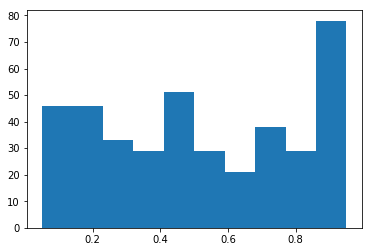

In [15]:
import matplotlib.pyplot as plt
plt.hist(submission_df['label'])

In [16]:
submission_df.head(5)

,filename,label
0,aassnaulhq.mp4,0.515137
1,aayfryxljh.mp4,0.117371
2,acazlolrpz.mp4,0.666992
3,adohdulfwb.mp4,0.106140
4,ahjnxtiamx.mp4,0.698730


In [17]:
submission_df.to_csv('submission.csv',index=False)